---
title: "filling gaps"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---



source: <https://github.com/carloalbe/fill-large-gaps-in-timeseries-using-forecasting>

In [1]:
#| code-summary: "import stuff"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing

# %matplotlib widget

In [2]:
#| code-summary: "load data as a dataframe"
df = pd.read_csv('dendrometer_sample.csv', parse_dates=['time'], index_col='time')
df = df['2020-01-01':'2020-01-31']
df = df.resample('1H').mean()

/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_22961/289532323.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').mean()


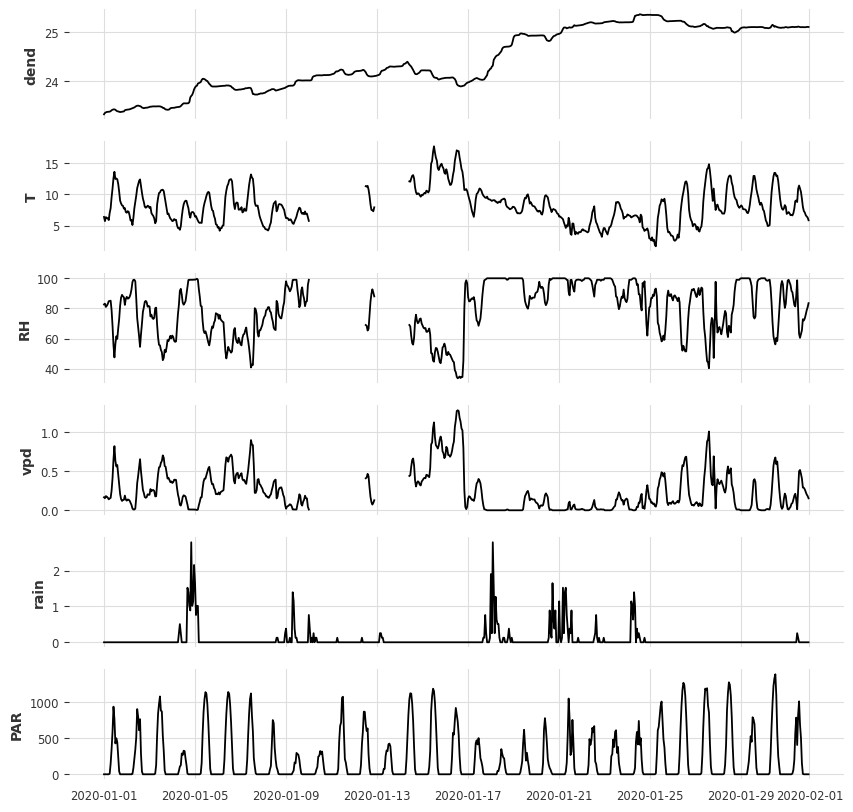

In [3]:
#| code-summary: "plot all columns"
columns = df.columns

fig, ax = plt.subplots(len(columns), 1, figsize=(10, 10), sharex=True)
for i, column in enumerate(columns):
    ax[i].plot(df.index, df[column])
    ax[i].set_ylabel(column)

Let's fill the gaps in the temperature column.

## forward

In [4]:
# find the time of the first nan in column 'T'
first_nan = df['T'].isnull().idxmax()
# find the time of the last nan in column 'T'
last_nan = df['T'].isnull()[::-1].idxmax()

one_hour = pd.Timedelta('1H')
missing_index = df[first_nan:last_nan].index

/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_22961/4122952174.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  one_hour = pd.Timedelta('1H')


In [5]:
data = TimeSeries.from_dataframe(df)
training_data_forward = data["T"].slice(df.index[0], first_nan - one_hour)

In [6]:
model_forward = ExponentialSmoothing()
model_forward.fit(series=training_data_forward)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0, kwargs=None)

In [7]:
N_to_fill = int((last_nan - first_nan) / one_hour) + 1
prediction = model_forward.predict(n=N_to_fill)
prediction;
df_pred_forward = pd.Series(data=prediction.values().flatten(), index=missing_index)

[Text(0.5, 0, '')]

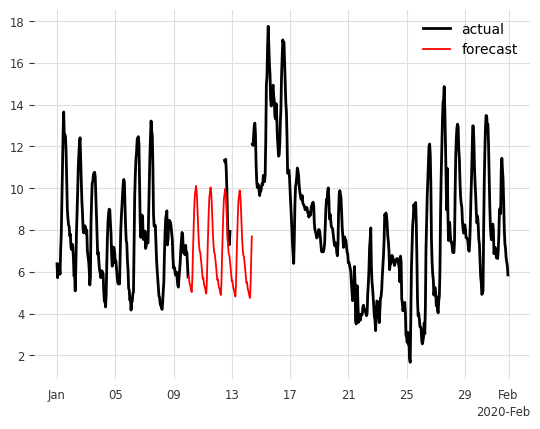

In [8]:
fig, ax = plt.subplots()
data['T'].plot(label='actual')
# prediction.plot(label='forecast', lw=2)
ax.plot(df_pred_forward, color='red', label='forecast')
ax.legend()
ax.set(xlabel="")

## backward

In [9]:
training_data2 = data["T"].slice(last_nan + one_hour, df.index[-1])
time_index = training_data2.time_index
values = training_data2.values()
reversed_values = values[::-1]
training_data_backward = TimeSeries.from_times_and_values(time_index, reversed_values)


In [10]:
model_backward = ExponentialSmoothing()
model_backward.fit(series=training_data_backward)


ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0, kwargs=None)

In [11]:
prediction2 = model_backward.predict(n=N_to_fill)
df_pred_backward = pd.Series(data=prediction2.values().flatten()[::-1], index=missing_index)

[Text(0.5, 0, '')]

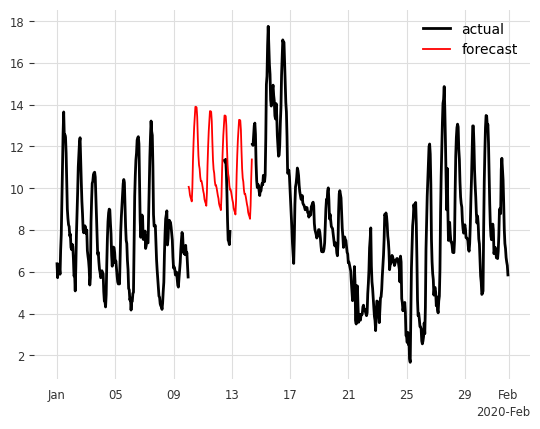

In [12]:
fig, ax = plt.subplots()
data['T'].plot(label='actual')
ax.plot(df_pred_backward, color='red', label='forecast')
ax.legend()
ax.set(xlabel="")

## interpolate

In [13]:
ramp = np.linspace(1, 0, N_to_fill)
interpolated = df_pred_forward * ramp + df_pred_backward * (1 - ramp)

[Text(0.5, 0, '')]

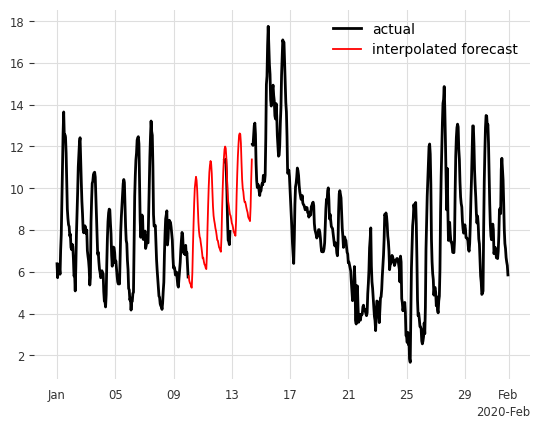

In [14]:
fig, ax = plt.subplots()
data['T'].plot(label='actual')
# prediction.plot(label='forecast', lw=2)
ax.plot(interpolated, color='red', label='interpolated forecast')
ax.legend()
ax.set(xlabel="")

[Text(0.5, 0, '')]

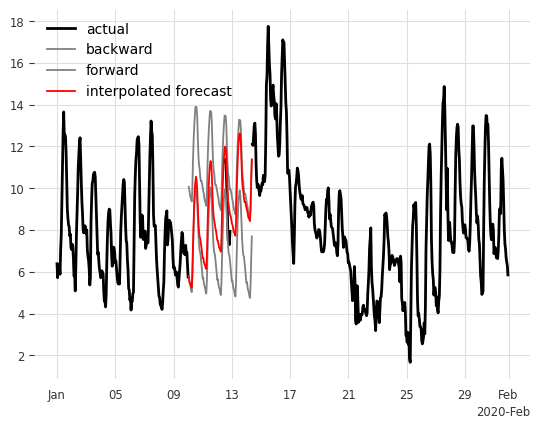

In [15]:
fig, ax = plt.subplots()
data['T'].plot(label='actual')
ax.plot(df_pred_backward, color='gray', label='backward')
ax.plot(df_pred_forward, color='gray', label='forward')
ax.plot(interpolated, color='red', label='interpolated forecast')
ax.legend()
ax.set(xlabel="")